In [1]:
import misc
import matplotlib as mpl
import os
import re
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr, mannwhitneyu
from collections import defaultdict
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, fcluster
import yaml
import sys

from misc import rename_cytokines, rename_CMs, rename_bloods, rename_factors, rename_Y, make_annot, convert_partial_year, rename_pathways, VISIT_TO_DAYS
import bcg_utils as utils

%load_ext autoreload
%autoreload 1
%aimport misc
%aimport bcg_utils
%aimport bcg_colors

from bcg_colors import *

In [2]:
_ = utils.setup_plotting(style='ticks', context='notebook', font_scale=1, rc=RC_PAPER)

FIG_SIZE = (1.25, 1.25)
HEATMAP_SIZE = (0.3, 0.3)
CIRCLE_SIZE = 20
CIRCLE_LINE_WIDTH = 0.4
ALPHA = 0.8
LGD_MARKER_SCALE = 1.2

FDR = [0.05]
ATAC_FDR = [0.1]
VOLCANO_MAX_ANNOT = 20
CELL_SIZE = 0.13
ENR_VMAX = 7
ENR_VMIN = -1 * ENR_VMAX
LM_VMAX = 5
LM_VMIN = -1 * LM_VMAX
AGE_EFFECT_PER_N_YEARS = 10
PVAL_ASTERISKS = [0.05, 0.01, 0.001]
CORR_CBAR_KWS = dict(shrink=2, aspect=0.15, orientation='horizontal')

SAVE_FIG = True
fig_dir = utils.make_dir('results', 'figures', 'Figure5')
CELLTYPE = 'PBMC'
TOP_N = 1000
RANK_METRIC = 'p.value'

EXCLUDE = r'C\.albicans\.yeast_24h_PBMC_IFNg|lactate'

# Suppl. Tables

In [3]:
SAVE_TABLES = True
if SAVE_TABLES:
    suppl_tables = misc.get_container_with_tables([IMMUNE_ANALYSIS], modes=['a'])


----------------------------
 F I X E D    E F F E C T S
----------------------------
results/LR/PBMC.final.WB_PER_ML.None.SAMPLE:VISIT//LR_results_WB_PER_ML.steady_state.remove_evening.SAMPLE:VISIT.csv


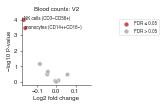

,,Coef,error,p.value,padj,resid.df,sample.size,stat,contrast_fdr,target_fdr,global_fdr
target,contrast,,,,,,,,,,
WB_PER_ML:NK,SAMPLE_VISIT[T.V2],-0.171166,0.043856,0.000106,0.001062,577.0,885.0,-3.902931,0.000106,0.001062,0.001062
WB_PER_ML:MONO/CLASSICAL,SAMPLE_VISIT[T.V2],-0.163227,0.045457,0.000358,0.001789,577.0,885.0,-3.590812,0.000358,0.001789,0.001789
WB_PER_ML:MONO/INTERMEDIATE,SAMPLE_VISIT[T.V2],-0.086657,0.047895,0.070924,0.236414,577.0,885.0,-1.809303,0.070924,0.236414,0.236414
WB_PER_ML:T/CD8,SAMPLE_VISIT[T.V2],-0.044918,0.036978,0.224968,0.562419,577.0,885.0,-1.214725,0.224968,0.562419,0.562419
WB_PER_ML:NKT,SAMPLE_VISIT[T.V2],-0.048791,0.050058,0.330117,0.567801,577.0,885.0,-0.974701,0.330117,0.567801,0.567801


,Log2 fold change,T-value,P-value,Adjusted P-value
Cell type,,,,
B cells (CD19+),0.002926,0.062576,0.950125,0.972800
Monocytes (CD14++CD16+),0.057704,0.953610,0.340680,0.567801
Monocytes (CD14++CD16−),-0.163227,-3.590812,0.000358,0.001789
Monocytes (CD14+CD16+),-0.086657,-1.809303,0.070924,0.236414
Neutrophils,0.010825,0.240924,0.809700,0.972800



----------------------------
 F I X E D    E F F E C T S
----------------------------
results/LR/PBMC.final.WB_PER_ML.None.SAMPLE:VISIT//LR_results_WB_PER_ML.steady_state.remove_evening.SAMPLE:VISIT.csv


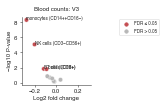

,,Coef,error,p.value,padj,resid.df,sample.size,stat,contrast_fdr,target_fdr,global_fdr
target,contrast,,,,,,,,,,
WB_PER_ML:MONO/CLASSICAL,SAMPLE_VISIT[T.V3],-0.276640,0.046592,5.000898e-09,5.000898e-08,577.0,885.0,-5.937472,5.000898e-09,5.000898e-08,5.000898e-08
WB_PER_ML:NK,SAMPLE_VISIT[T.V3],-0.201791,0.044951,8.639363e-06,4.319681e-05,577.0,885.0,-4.489089,8.639363e-06,4.319681e-05,4.319681e-05
WB_PER_ML:B,SAMPLE_VISIT[T.V3],-0.116970,0.047928,1.496484e-02,4.015266e-02,577.0,885.0,-2.440546,1.496484e-02,4.015266e-02,4.015266e-02
WB_PER_ML:T/CD8,SAMPLE_VISIT[T.V3],-0.091518,0.037902,1.606106e-02,4.015266e-02,577.0,885.0,-2.414634,1.606106e-02,4.015266e-02,4.015266e-02
WB_PER_ML:T/CD4/TREG,SAMPLE_VISIT[T.V3],-0.084333,0.056945,1.391652e-01,2.783303e-01,577.0,885.0,-1.480952,1.391652e-01,2.783303e-01,2.783303e-01


,Log2 fold change,T-value,P-value,Adjusted P-value
Cell type,,,,
B cells (CD19+),-0.116970,-2.440546,1.496484e-02,4.015266e-02
Monocytes (CD14++CD16+),-0.019542,-0.315074,7.528194e-01,7.528194e-01
Monocytes (CD14++CD16−),-0.276640,-5.937472,5.000898e-09,5.000898e-08
Monocytes (CD14+CD16+),-0.061311,-1.248906,2.122061e-01,3.536768e-01
Neutrophils,0.037388,0.811842,4.172170e-01,5.215213e-01



----------------------------
 F I X E D    E F F E C T S
----------------------------
results/LR/PBMC.final.CM.WHOLE_BLOOD.SAMPLE:VISIT//LR_results_CM.steady_state.remove_evening.SAMPLE:VISIT.csv


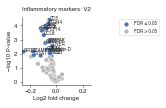

,,Coef,error,p.value,padj,resid.df,sample.size,stat,contrast_fdr,target_fdr,global_fdr
target,contrast,,,,,,,,,,
CM:CD5_P06127,SAMPLE_VISIT[T.V2],-0.054259,0.013125,0.000041,0.002324,561.0,879.0,-4.133922,0.000041,0.002324,0.002324
CM:CD244_Q9BZW8,SAMPLE_VISIT[T.V2],-0.061879,0.015566,0.000080,0.002324,561.0,879.0,-3.975217,0.000080,0.002324,0.002324
CM:CD40_P25942,SAMPLE_VISIT[T.V2],-0.083057,0.021245,0.000104,0.002324,561.0,879.0,-3.909521,0.000104,0.002324,0.002324
CM:CD6_Q8WWJ7,SAMPLE_VISIT[T.V2],-0.073552,0.019307,0.000155,0.002324,561.0,879.0,-3.809545,0.000155,0.002324,0.002324
CM:CASP.8_Q14790,SAMPLE_VISIT[T.V2],-0.120167,0.031605,0.000159,0.002324,561.0,879.0,-3.802102,0.000159,0.002324,0.002324


,Log2 fold change,T-value,P-value,Adjusted P-value
Inflammatory marker,,,,
4E-BP1,-0.099157,-1.423852,0.155045,0.217660
ADA,-0.037877,-2.464105,0.014034,0.046569
Axin-1,-0.141325,-1.949143,0.051776,0.107991
CASP-8,-0.120167,-3.802102,0.000159,0.002324
CCL11,-0.035484,-1.625739,0.104567,0.173486



----------------------------
 F I X E D    E F F E C T S
----------------------------
results/LR/PBMC.final.CM.WHOLE_BLOOD.SAMPLE:VISIT//LR_results_CM.steady_state.remove_evening.SAMPLE:VISIT.csv


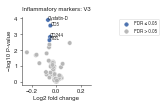

,,Coef,error,p.value,padj,resid.df,sample.size,stat,contrast_fdr,target_fdr,global_fdr
target,contrast,,,,,,,,,,
CM:CST5_P28325,SAMPLE_VISIT[T.V3],-0.069097,0.017870,0.000123,0.009000,561.0,879.0,-3.866589,0.000123,0.009000,0.009000
CM:CD5_P06127,SAMPLE_VISIT[T.V3],-0.050348,0.013774,0.000281,0.010257,561.0,879.0,-3.655298,0.000281,0.010257,0.010257
CM:CD244_Q9BZW8,SAMPLE_VISIT[T.V3],-0.052245,0.016336,0.001461,0.035548,561.0,879.0,-3.198201,0.001461,0.035548,0.035548
CM:Flt3L_P49771,SAMPLE_VISIT[T.V3],-0.057375,0.018742,0.002309,0.042130,561.0,879.0,-3.061402,0.002309,0.042130,0.042130
CM:IL8_P10145,SAMPLE_VISIT[T.V3],0.108735,0.037089,0.003508,0.051221,561.0,879.0,2.931725,0.003508,0.051221,0.051221


,Log2 fold change,T-value,P-value,Adjusted P-value
Inflammatory marker,,,,
4E-BP1,-0.085909,-1.175507,0.240291,0.584707
ADA,-0.006978,-0.432599,0.665473,0.867491
Axin-1,-0.140182,-1.842294,0.065960,0.283239
CASP-8,-0.080284,-2.420546,0.015814,0.128267
CCL11,0.013626,0.594873,0.552168,0.832658



----------------------------
 F I X E D    E F F E C T S
----------------------------
results/LR/PBMC.final.CYTO.BLOOD.SAMPLE:VISIT//LR_results_CYTO.steady_state.remove_evening.SAMPLE:VISIT.csv


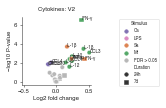

,,Coef,error,p.value,padj,resid.df,sample.size,stat,contrast_fdr,target_fdr,global_fdr
target,contrast,,,,,,,,,,
CYTO:MTB_7d_PBMC_IFNg_good,SAMPLE_VISIT[T.V2],0.388043,0.074725,2.985602e-07,0.000008,515.0,828.0,5.192947,2.985602e-07,0.000008,0.000008
CYTO:S.aureus_24h_PBMC_IL.1b_good,SAMPLE_VISIT[T.V2],0.162935,0.043346,1.889762e-04,0.002646,547.0,860.0,3.758959,1.889762e-04,0.002646,0.002646
CYTO:MTB_24h_PBMC_IL.1b_good,SAMPLE_VISIT[T.V2],0.417467,0.115209,3.207402e-04,0.002994,493.0,782.0,3.623552,3.207402e-04,0.002994,0.002994
CYTO:MTB_24h_PBMC_MIP1a_good,SAMPLE_VISIT[T.V2],0.507380,0.150100,7.992176e-04,0.005595,380.0,653.0,3.380272,7.992176e-04,0.005595,0.005595
CYTO:MTB_24h_PBMC_IL.10_good,SAMPLE_VISIT[T.V2],0.241402,0.077487,1.943152e-03,0.010882,497.0,786.0,3.115394,1.943152e-03,0.010882,0.010882


,Log2 fold change,T-value,P-value,Adjusted P-value
Cytokine,,,,
"CCL3 (Ca, 24h)",-0.024276,-0.658462,0.510532,0.621518
"CCL3 (Mt, 24h)",0.507380,3.380272,0.000799,0.005595
"CCL4 (Ca, 24h)",-0.079797,-2.634448,0.008668,0.022064
"CCL4 (Mt, 24h)",0.240852,2.770555,0.005816,0.018095
"CXCL10 (Ca, 24h)",-0.118083,-2.480375,0.013428,0.028922



----------------------------
 F I X E D    E F F E C T S
----------------------------
results/LR/PBMC.final.CYTO.BLOOD.SAMPLE:VISIT//LR_results_CYTO.steady_state.remove_evening.SAMPLE:VISIT.csv


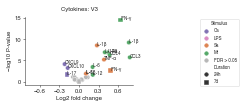

,,Coef,error,p.value,padj,resid.df,sample.size,stat,contrast_fdr,target_fdr,global_fdr
target,contrast,,,,,,,,,,
CYTO:MTB_7d_PBMC_IFNg_good,SAMPLE_VISIT[T.V3],0.637665,0.078321,2.955857e-15,8.276400e-14,515.0,828.0,8.141716,2.955857e-15,8.276400e-14,8.276400e-14
CYTO:MTB_24h_PBMC_IL.1b_good,SAMPLE_VISIT[T.V3],0.765741,0.121258,6.037339e-10,8.452274e-09,493.0,782.0,6.314969,6.037339e-10,8.452274e-09,8.452274e-09
CYTO:S.aureus_24h_PBMC_IL.1b_good,SAMPLE_VISIT[T.V3],0.275376,0.045593,2.851831e-09,2.661709e-08,547.0,860.0,6.039825,2.851831e-09,2.661709e-08,2.661709e-08
CYTO:MTB_24h_PBMC_IL.1ra_good,SAMPLE_VISIT[T.V3],0.396004,0.073643,1.165537e-07,7.173366e-07,497.0,786.0,5.377314,1.165537e-07,7.173366e-07,7.173366e-07
CYTO:MTB_24h_PBMC_IL.10_good,SAMPLE_VISIT[T.V3],0.438922,0.081899,1.280958e-07,7.173366e-07,497.0,786.0,5.359290,1.280958e-07,7.173366e-07,7.173366e-07


,Log2 fold change,T-value,P-value,Adjusted P-value
Cytokine,,,,
"CCL3 (Ca, 24h)",-0.066653,-1.701921,8.936673e-02,0.125113
"CCL3 (Mt, 24h)",0.780120,4.845447,1.843313e-06,0.000007
"CCL4 (Ca, 24h)",-0.035870,-1.125384,2.609234e-01,0.347898
"CCL4 (Mt, 24h)",0.470570,5.107187,4.749733e-07,0.000002
"CXCL10 (Ca, 24h)",-0.173288,-3.462366,5.778866e-04,0.001471


In [4]:
for model_prefix, Y_name, blood, factors_kind, fdr_pass_color, exclude_targets in [
    ('final', 'WB_PER_ML', None, 'SAMPLE:VISIT', RED, None),
    ('final', 'CM', 'WHOLE_BLOOD', 'SAMPLE:VISIT', BLUE, None),
    ('final', 'CYTO', 'BLOOD', 'SAMPLE:VISIT', None, EXCLUDE)
]:
    for visit in ['V2', 'V3']:
        if visit == 'V3':
            if Y_name == 'WB_PER_ML':
                xticks, scale_width, xlim_scale, fig_n = [-0.2, 0, 0.2], 1, 1.1, 'S4A'
            elif Y_name == 'CM':
                xticks, scale_width, xlim_scale, fig_n = None, 1, 1.1, 'S4B'
            elif Y_name == 'CYTO':
                xticks, scale_width, xlim_scale, fig_n = [-0.6, -0.3, 0, 0.3, 0.6], 1.55, 1, '5B'
            else:
                xticks, scale_width, xlim_scale, fig_n = None, 1, 1, None
        else:
                xticks, scale_width, xlim_scale, fig_n = None, 1, 1, None
                
        res_df, pvals_df, joint_df, de_df = misc.factor_analysis(
            celltype=CELLTYPE, model='{}.{}.{}.{}'.format(model_prefix, Y_name, blood, factors_kind), Y_name=Y_name, factors_kind=factors_kind,
            subset_factors=f'SAMPLE:VISIT[T.{visit}]', exclude_targets=exclude_targets, annot_col='target_fdr',
            visits=None, visit_interaction=None, fold_changes=None, LMM=False, remove_evening=True,
            factor_volcanos=True, joint_volcano=False, heatmap=False, fdr=FDR,
            age_effect_per_N_years=AGE_EFFECT_PER_N_YEARS,
            color_by_stimulus=True, marker_by_duration=True,
            scatter_kws=dict(linewidth=CIRCLE_LINE_WIDTH, markers=['o', 's']),
            legend_kws=dict(bbox_to_anchor=(2, 1), title=None if fdr_pass_color else 'Stimulus',
                            ncol=1, markerscale=LGD_MARKER_SCALE, fontsize=SMALL_FONT),
            volcano_kws=dict(size=CIRCLE_SIZE, alpha=None, figsize=(FIG_SIZE[0] * scale_width, FIG_SIZE[1]), rasterized=False,
                             sharex=False, sharey=False, xlabel='Log2 fold change', fdr_with_hue=True,
                             fdr_pass_color=fdr_pass_color, palette=list(STIMULUS_COLORS.values()),
                             fdr_fail_color=LIGHT_GRAY, fdr_prefix='FDR ', centre=True, xticks=xticks, xlim_scale=xlim_scale),
            annot_kws={},
            cbar_kws={},
            heatmap_kws=dict(vmin=LM_VMIN, vmax=LM_VMAX),
            annot_size=SMALL_FONT, max_annot=VOLCANO_MAX_ANNOT,
            cell_width=CELL_SIZE, cell_height=CELL_SIZE, names_without_time=False, names_without_stimulus=False, blank_no_significance=False,
            pval_asterisks=PVAL_ASTERISKS, pval_fmt='.0e',
            cbar_label='{}log P-value'.format(utils.MINUS),
            padj_method='fdr_bh', fig_dir=fig_dir, save_fig=SAVE_FIG, show_fig=True,
            fig_format=dict(pvals_heatmap='pdf', volcanos='svg', joint_volcano='pdf'), dpi=DPI)
        display(res_df.sort_values('p.value').head())

        if SAVE_TABLES:
            suppl_df = misc.suppl_table_immune_LFC(res_df, Y_name, visit, suppl_tables=suppl_tables, table_name=IMMUNE_ANALYSIS, fig_n=fig_n)
            display(suppl_df.head())

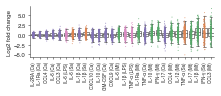

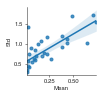

In [5]:
df = misc.get_sample_annot()
df = df.loc[(df['SAMPLE:VISIT'] == 'V3') & (df['SAMPLE:TISSUE'] == 'PBMC') & ~df['DONOR:IC_EVENING'], df.columns.str.contains('^LFC_CORR_CYTO:.*_good$') & ~df.columns.str.contains(EXCLUDE)]
df.columns = df.columns.str.replace('^LFC_CORR_', '')
df = df.loc[~df.isnull().all(axis=1)]
# df = df.iloc[:, misc.argsort_cytokines(df.columns)]
df = df.iloc[:, np.argsort(df.std())]
stimuli = misc.rename_cytokines(df.columns, only_stimulus=True)
stimuli = stimuli.astype(object)
stimuli[stimuli == 'Ca'] = PURPLE
stimuli[stimuli == 'LPS'] = PINK
stimuli[stimuli == 'Mt'] = GREEN
stimuli[stimuli == 'Sa'] = ORANGE
cytokines = misc.rename_cytokines(df.columns, only_cyto=True)
df.columns = misc.rename_cytokines(df.columns)
fig, ax = plt.subplots(1, 1, figsize=(3.3, FIG_SIZE[1] * 0.75))

ax = utils.stripplot(data=df, orient='v', s=1, alpha=ALPHA, palette=stimuli, rasterized=RASTER, random_state=misc.RANDOM_STATE)
ax = sns.boxplot(data=df, orient='v', fliersize=0, color='gray')
plt.setp(ax.artists, edgecolor='k', facecolor='w', lw=0.5)
plt.setp(ax.lines, color='k', lw=0.5)
    
# sns.boxplot(data=df, fliersize=0,  orient='v', ax=ax)
# for box, color in zip(ax.artists, stimuli):
#     plt.setp(box, facecolor=color)
# plt.setp(ax.lines, lw=0.3)
# plt.setp(ax.artists, lw=0.3)
ax.set_yticks([-5, -2.5, 0, 2.5, 5])
ax.set_ylabel('Log2 fold change')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=SMALL_FONT, rotation=90)
sns.despine()
if SAVE_FIG:
    utils.savefig(os.path.join(fig_dir, 'fc_range.svg'), dpi=DPI)
plt.show()

fig, ax = plt.subplots(figsize=FIG_SIZE)
ax = sns.regplot(x=df.mean().abs(), y=df.std(), robust=True)
ax.set_xlabel("Mean")
ax.set_ylabel("Std")
sns.despine()
plt.show()

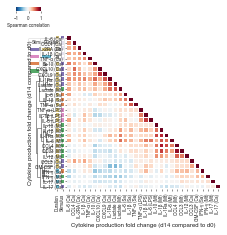

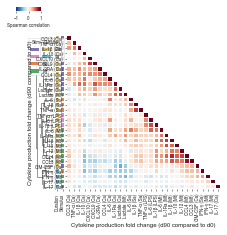

IFN-γ (Mt) IL-6 (Sa) -0.28628726289092393
IL-6 (Mt) IL-6 (Sa) 0.5171053811694473
Lactate (Ca) IL-6 (Sa) 0.2261342685994651
IL-6 (Sa) Lactate (Mt) 0.33362101927364674
IFN-γ (Mt) Lactate (Mt) -0.45321385694787436


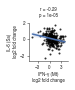

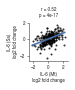

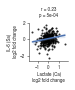

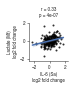

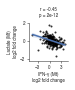

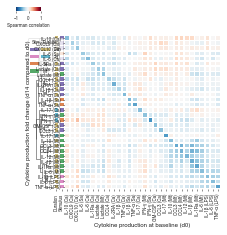

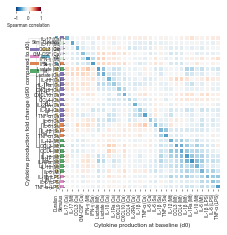

Spearman R       P-value
Data            Cytokine 1      Cytokine 2                                 
All time points CCL3 (Ca, 24h)  CCL3 (Mt, 24h)       0.177090  7.513056e-06
                                CCL4 (Ca, 24h)       0.504877  2.430560e-55
                                CCL4 (Mt, 24h)       0.280934  8.478223e-15
                                CXCL10 (Ca, 24h)    -0.004679  8.926750e-01
                                CXCL9 (Ca, 24h)     -0.035778  3.009078e-01
...                                                       ...           ...
d0 with d90FC   TNF-α (Sa, 24h) Lactate (Ca, 24h)   -0.012190  8.419603e-01
                                Lactate (Mt, 24h)   -0.053372  4.017187e-01
                                TNF-α (Ca, 24h)     -0.098674  1.274103e-01
                                TNF-α (LPS, 24h)    -0.077380  2.163458e-01
                                TNF-α (Sa, 24h)     -0.552110  3.493081e-23

[3105 rows x 2 columns]

In [6]:
corr_suppl = {}
df = misc.get_sample_annot()
corr_Y_name = 'CYTO'
corr_suppl_index = lambda x: ['Data', f'{LONG_NAMES[x]} 1', f'{LONG_NAMES[x]} 2']
corr_sheet_name = f'{NAMES[corr_Y_name]}_corr'
corr_suppl['All time points'] = pd.read_excel(suppl_tables[IMMUNE_ANALYSIS]['filename'],
                                              sheet_name=corr_sheet_name,
                                              index_col=[0, 1, 2])
assert corr_suppl['All time points'].index.names == corr_suppl_index(corr_Y_name)

for xlabel, visit_x, regex_x, ylabel, visit_y, regex_y, symmetrical, suppl_data_Y_name, annot, rename_y, apply_X_clusters_to_Y, fn, show_examples, fig_n in [
#     ('Steady-state (d0)', 'V1', '^CYTO:.*_good',
#      'Steady-state (d0)', 'V1', '^CYTO:.*_good',
#      True, None, None, misc.rename_cytokines, True, 'V1_cyto_correlation.pdf', False, None),

    ('Cytokine production fold change (d{} compared to d0)', None, '^LFC_CYTO:.*_good',
     'Cytokine production fold change (d{} compared to d0)', None, '^LFC_CYTO:.*_good',
     True, 'CYTO', None, misc.rename_cytokines, True, '{}_fold_changes_cyto_correlation.svg', True, '5D'),

#     ('d{} corrected fold changes', None, '^LFC_CORR_CYTO:.*_good',
#      'd{} corrected fold changes', None, '^LFC_CORR_CYTO:.*_good',
#      True, None, None, misc.rename_cytokines, True, '{}_fold_changes_corr_cyto_correlation.pdf', True, None),

    ('Cytokine production at baseline (d0)', 'V1', '^CYTO:.*_good',
     'Cytokine production fold change (d{} compared to d0)', None, '^LFC_CYTO:.*_good',
     False, 'CYTO', None, misc.rename_cytokines, True, '{}_cyto_fold_changes_V1_cyto_correlation.svg', False, 'S4C'),

#     ('Adjusted cytokine production at baseline (d0)', 'V1', '^V1_CORR_CYTO:.*_good',
#      'Adjusted cytokine production fold change (d{} compared to d0)', None, '^LFC_CORR_CYTO:.*_good',
#      False, None, None, misc.rename_cytokines, True, '{}_fold_changes_corr_cyto_V1_corr_cyto_correlation.pdf', False, None),

#     ('Steady-state (d0)', 'V1', '^CYTO:.*_good',
#      'Steady-state (d0)', 'V1', '^CM:',
#      False, None, 'pval', misc.rename_CMs, False, 'V1_cyto_V1_CM_correlation.pdf', False, None),

#     ('d{} fold changes', None, '^LFC_CYTO:.*_good',
#      'Steady-state (d0)', 'V1', '^CM:',
#      False, None, 'pval', misc.rename_CMs, False, '{}_fold_changes_cyto_V1_CM_correlation.pdf', False, None),

#     ('d{} corrected fold changes', None, '^LFC_CORR_CYTO:.*_good',
#      'Corrected steady-state (d0)', 'V1', '^V1_CORR_CM:',
#      False, None, 'pval', misc.rename_CMs, False, '{}_fold_changes_corr_cyto_V1_corr_CM_correlation.pdf', False, None),

#     ('Steady-state (d0)', 'V1', '^CYTO:.*_good',
#      'Steady-state (d0)', 'V1', misc.WHOLE_BLOOD,
#      False, None, 'pval', rename_bloods, False, 'V1_cyto_V1_blood_correlation.pdf', False, None),

#     ('d{} fold changes', None, '^LFC_CYTO:.*_good',
#      'Steady-state (d0)', 'V1', misc.WHOLE_BLOOD,
#      False, None, 'pval', rename_bloods, False, '{}_fold_changes_cyto_V1_blood_correlation.pdf', False, None)
]:
    for visit in [
        'V2',
        'V3'
    ]:
        
        df_x = df.loc[(df['SAMPLE:VISIT'] == (visit_x if visit_x is not None else visit)) & (df['SAMPLE:TISSUE'] == 'PBMC'), df.columns.str.contains(regex_x) if isinstance(regex_x, str) else regex_x]
        df_y = df.loc[(df['SAMPLE:VISIT'] == (visit_y if visit_y is not None else visit)) & (df['SAMPLE:TISSUE'] == 'PBMC'), df.columns.str.contains(regex_y) if isinstance(regex_y, str) else regex_y]
        if (visit_x if visit_x is not None else visit) != 'V1':
            df_x = df_x.loc[~df.loc[df_x.index, 'DONOR:IC_EVENING']]
        if (visit_y if visit_y is not None else visit) != 'V1':
            df_y = df_y.loc[~df.loc[df_y.index, 'DONOR:IC_EVENING']]
        df_x.columns = df_x.columns.str.replace('^LFC_', '').str.replace('^CORR_', '').str.replace('^V1_CORR_', '')
        df_y.columns = df_y.columns.str.replace('^LFC_', '').str.replace('^CORR_', '').str.replace('^V1_CORR_', '')
        df_x.index = df_x.index.str.split('_', expand=True).get_level_values(0)
        df_y.index = df_y.index.str.split('_', expand=True).get_level_values(0)
        assert df_x.index.is_unique and df_y.index.is_unique

        duration = misc.rename_cytokines(df_x.columns, only_time=True)
        stimulus = misc.rename_cytokines(df_x.columns, only_stimulus=True, with_time=False)

        raw_df_x_columns = df_x.columns
        raw_df_y_columns = df_y.columns
        df_x.columns = misc.rename_cytokines(df_x.columns)
        df_y.columns = rename_y(df_y.columns)

        duration = pd.Series(np.asarray(duration), index=df_x.columns, name='Duration').map(DURATION_COLORS)
        stimulus = pd.Series(np.asarray(stimulus), index=df_x.columns, name='Stimulus').map(STIMULUS_COLORS)
        row_colors = pd.concat([duration, stimulus], axis=1)

        cg, corr_df, pval_df, padj_df = utils.corr_heatmap_with_pvals(
            df_x, df_y, corr_method='spearman', apply_X_clusters_to_Y=apply_X_clusters_to_Y, optimal_ordering=True,
            padj_method='fdr_bh', pval_asterisks=True, annot=annot, xlabel=xlabel.format(VISIT_TO_DAYS[visit]), ylabel=ylabel.format(VISIT_TO_DAYS[visit]),
            do_not_test_diag=symmetrical, lower_tria=symmetrical, cluster=True, row_colors=row_colors, col_colors=None,
            # this how to make "quite" square
            dendrogram_ratio=0.1, colors_ratio=0.02825, cell_width=0.114, cell_height=0.1075 + (0.1 if df_y.shape[1] < df_x.shape[1] else 0), lw=0.5,
            vmin=-1, vmax=1, cbar_kws=dict(orientation='horizontal'), cbar_pos=(-0.05, 1, 0.1, 0.02),
            title=None, annot_size=ASTERISK_FONT, fig_fn=None, title_offset=1)

        cg.ax_col_dendrogram.set_visible(not apply_X_clusters_to_Y)
        utils.clustermap_legend(ax=cg.ax_row_dendrogram, color_codes=STIMULUS_COLORS, bbox_to_anchor=(1.1, 1), title='Stimulus', fontsize=SMALL_FONT)
        utils.clustermap_legend(ax=cg.ax_row_colors, color_codes=DURATION_COLORS, bbox_to_anchor=(1.1, 1), title='Duration', fontsize=SMALL_FONT)
        cg.ax_heatmap.tick_params(axis='both', which='both', labelsize=SMALL_FONT)
        cg.ax_cbar.tick_params(axis='both', which='both', labelsize=SMALL_FONT)
        cg.ax_row_dendrogram.tick_params(axis='both', which='both', labelsize=SMALL_FONT)
        cg.ax_row_colors.tick_params(axis='both', which='both', labelsize=SMALL_FONT)
        cg.ax_cbar.set_xlabel(cg.ax_cbar.get_xlabel(), fontsize=SMALL_FONT)
        cg.ax_cbar.set_ylabel(cg.ax_cbar.get_ylabel(), fontsize=SMALL_FONT)
        if apply_X_clusters_to_Y:
            cg.ax_heatmap.yaxis.set_label_position('left')
            cg.ax_heatmap.yaxis.tick_left()
            cg.ax_row_colors.yaxis.set_label_position('left')
            cg.ax_row_colors.yaxis.tick_left()
        if SAVE_FIG:
            utils.savefig(os.path.join(fig_dir, fn.format(visit)))
        plt.show()

        if show_examples and visit == 'V3':
            for x, y, xticks, yticks in [
                ('IFN-γ (Mt)', 'IL-6 (Sa)', [-3, 0, 3], None),
                ('IL-6 (Mt)', 'IL-6 (Sa)', [-2, 0, 2], None),
                ('Lactate (Ca)', 'IL-6 (Sa)', None, None),
                ('IL-6 (Sa)', 'Lactate (Mt)', [-2, 0, 2], [-2, 0, 2]),
                ('IFN-γ (Mt)', 'Lactate (Mt)', [-3, 0, 3], [-2, 0, 2]),
            ]:
                fig, ax = plt.subplots(1, 1, figsize=(0.7, 0.7))
                ax = sns.regplot(df_x[x], df_y[y],
                                 line_kws=dict(color=BLUE),
                                 scatter_kws=dict(color='black', s=CIRCLE_SIZE * 0.2, alpha=ALPHA, edgecolor='red',
                                                  lw=0, rasterized=RASTER), ax=ax)
                print(x, y, corr_df.loc[x, y])
                assert padj_df.loc[x, y] < 0.05
                ax.set_title('r = {:.2f}\np = {:.0e}'.format(corr_df.loc[x, y], padj_df.loc[x, y]), fontsize=SMALL_FONT)
                ax.set_xlabel('{}\nlog2 fold change'.format(ax.get_xlabel()), fontsize=SMALL_FONT)
                ax.set_ylabel('{}\nlog2 fold change'.format(ax.get_ylabel()), fontsize=SMALL_FONT)
                if xticks is not None:
                    ax.set_xticks(xticks)
                if yticks is not None:
                    ax.set_yticks(yticks)
                plt.setp(ax.get_xticklabels(), fontsize=SMALL_FONT)
                plt.setp(ax.get_yticklabels(), fontsize=SMALL_FONT)

                fx = (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.1
                fy = (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.05
                ax.set_xlim(ax.get_xlim()[0] - fx, ax.get_xlim()[1] + fx)
                ax.set_ylim(ax.get_ylim()[0] - fy, ax.get_ylim()[1])

                sns.despine()
                if SAVE_FIG:
                    utils.savefig(os.path.join(fig_dir, 'example_regplots_corrected.{}.{}.svg'.format(x, y)), dpi=DPI)
              
        corr_df.columns, pval_df.columns = raw_df_x_columns, raw_df_x_columns
        corr_df.index, pval_df.index = raw_df_y_columns, raw_df_y_columns
        
        if suppl_data_Y_name and SAVE_TABLES:
            assert suppl_data_Y_name == corr_Y_name
            k = f'{misc.get_day_suffix(visit_x if visit_x is not None else visit)} with {misc.get_day_suffix(visit_y if visit_y is not None else visit)}'
            corr_suppl[k] = misc.suppl_table_immune_LFC_corr(
                corr_df, pval_df, suppl_data_Y_name, (visit_x if visit_x is not None else visit), (visit_y if visit_y is not None else visit), symmetrical, suppl_tables=None)

if SAVE_TABLES:
    for k in corr_suppl:
        if 'Data' not in corr_suppl[k].index.names:
            corr_suppl[k].index.names = [f'{LONG_NAMES[corr_Y_name]} 1', f'{LONG_NAMES[corr_Y_name]} 2']
            corr_suppl[k]['Data'] = k
            corr_suppl[k] = corr_suppl[k].reset_index().set_index(corr_suppl_index(corr_Y_name))
    suppl_df = pd.concat([corr_suppl[k] for k in corr_suppl])
    suppl_tables[IMMUNE_ANALYSIS]['info'][corr_sheet_name] = f'Pairwise Spearman correlations of 28 ex vivo cytokine-stimulus and two lactate-stimulus production capacity measurements and BCG-induced changes in {HUMAN_NAMES[Y_name]}{misc.related_to_fig_str("1D, 5D, and S4C")}.'
    suppl_tables[IMMUNE_ANALYSIS]['header_rows'][corr_sheet_name] = len(suppl_df.columns.names)
    suppl_tables[IMMUNE_ANALYSIS]['index_cols'][corr_sheet_name] = len(suppl_df.index.names)
    misc.save_excel(suppl_df, suppl_tables[IMMUNE_ANALYSIS]['file'], sheet_name=corr_sheet_name)
    display(suppl_df)


----------------------------
I N T E R A C T I O N --- V2
----------------------------
results/LR/PBMC.final.CYTO.None//LR_results_CYTO.visit_interaction.LMM.remove_evening.include_blood_per_ml.csv


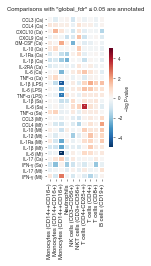

,,Coef,error,p.value,padj,resid.df,sample.size,stat,contrast_fdr,target_fdr,global_fdr
target,contrast,,,,,,,,,,
CYTO:MTB_24h_PBMC_IL.6_good,IC_WB_PER_ML_MONO_NON_CLASSICAL,-6.049694,1.354740,0.000010,0.002759,506.939785,788.0,-4.465577,0.000099,0.000276,0.002759
CYTO:LPS.100ng_24h_PBMC_IL.1b_good,IC_WB_PER_ML_MONO_NON_CLASSICAL,-6.086715,1.513388,0.000066,0.009194,558.403747,863.0,-4.021915,0.000657,0.000919,0.009194
CYTO:S.aureus_24h_PBMC_IL.6_good,IC_WB_PER_ML_T_CD4_TREG,6.600223,1.736385,0.000160,0.014892,569.664819,862.0,3.801129,0.001596,0.004468,0.014892
CYTO:LPS.100ng_24h_PBMC_TNF.a_good,IC_WB_PER_ML_MONO_NON_CLASSICAL,-6.021878,1.643720,0.000274,0.019148,533.986236,824.0,-3.663566,0.002735,0.002553,0.019148
CYTO:MTB_7d_PBMC_IFNg_good,IC_WB_PER_ML_MONO_NON_CLASSICAL,6.161698,2.007772,0.002258,0.122058,529.468894,831.0,3.068923,0.022584,0.014690,0.122058



----------------------------
I N T E R A C T I O N --- V3
----------------------------
results/LR/PBMC.final.CYTO.None//LR_results_CYTO.visit_interaction.LMM.remove_evening.include_blood_per_ml.csv


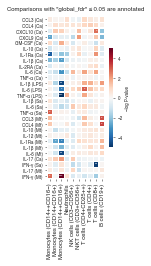

,,Coef,error,p.value,padj,resid.df,sample.size,stat,contrast_fdr,target_fdr,global_fdr
target,contrast,,,,,,,,,,
CYTO:LPS.100ng_24h_PBMC_TNF.a_good,IC_WB_PER_ML_MONO_NON_CLASSICAL,-9.477582,1.645291,1.420407e-08,0.000004,532.264750,824.0,-5.760430,1.420407e-07,3.977140e-07,0.000004
CYTO:MTB_7d_PBMC_IFNg_good,IC_WB_PER_ML_MONO_NON_CLASSICAL,9.298762,2.009327,4.653258e-06,0.000651,529.457289,831.0,4.627799,4.653258e-05,6.514562e-05,0.000651
CYTO:S.aureus_7d_PBMC_IFNg_good,IC_WB_PER_ML_T_CD8,-2.548701,0.587915,1.782290e-05,0.001562,471.034810,686.0,-4.335154,1.782290e-04,4.990412e-04,0.001562
CYTO:LPS.100ng_24h_PBMC_IL.1b_good,IC_WB_PER_ML_MONO_NON_CLASSICAL,-6.454461,1.523460,2.652235e-05,0.001562,559.531407,863.0,-4.236712,2.652235e-04,1.952321e-04,0.001562
CYTO:MTB_24h_PBMC_IL.6_good,IC_WB_PER_ML_MONO_NON_CLASSICAL,-5.767514,1.363925,2.789030e-05,0.001562,508.013963,788.0,-4.228615,2.789030e-04,1.952321e-04,0.001562



----------------------------
I N T E R A C T I O N --- V2
----------------------------
results/LR/PBMC.final.CYTO.BLOOD//LR_results_CYTO.visit_interaction.LMM.remove_evening.csv


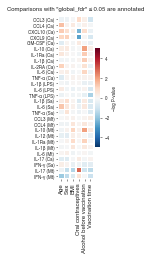

,,Coef,error,p.value,padj,resid.df,sample.size,stat,contrast_fdr,target_fdr,global_fdr
target,contrast,,,,,,,,,,
CYTO:MTB_7d_PBMC_IL.17_good,DONOR_oralContraceptivesIncludingMen,0.599286,0.185987,0.001349,0.161601,536.090693,830.0,3.222186,0.008097,0.026934,0.161601
CYTO:C.albicans.yeast_24h_PBMC_MIG_good,DONOR_oralContraceptivesIncludingMen,-0.302815,0.097151,0.001924,0.161601,543.426141,856.0,-3.116970,0.011543,0.026934,0.161601
CYTO:C.albicans.yeast_24h_PBMC_IP10_good,DONOR_oralContraceptivesIncludingMen,-0.250258,0.087924,0.004591,0.257081,542.286874,852.0,-2.846282,0.027544,0.042847,0.257081
CYTO:MTB_24h_PBMC_IL.10_good,DONOR_IC_alcoholInLast24h,0.304577,0.115566,0.008574,0.293945,752.280059,778.0,2.635522,0.051443,0.122477,0.293945
CYTO:C.albicans.yeast_24h_PBMC_IL.10_good,DONOR_IC_alcoholInLast24h,0.200649,0.076349,0.008748,0.293945,819.600159,850.0,2.628045,0.052490,0.122477,0.293945



----------------------------
I N T E R A C T I O N --- V3
----------------------------
results/LR/PBMC.final.CYTO.BLOOD//LR_results_CYTO.visit_interaction.LMM.remove_evening.csv


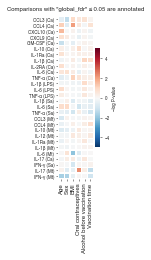

,,Coef,error,p.value,padj,resid.df,sample.size,stat,contrast_fdr,target_fdr,global_fdr
target,contrast,,,,,,,,,,
CYTO:MTB_7d_PBMC_IL.17_good,DONOR_oralContraceptivesIncludingMen,0.536640,0.188743,0.004635,0.546901,540.363939,830.0,2.843229,0.027809,0.129777,0.546901
CYTO:C.albicans.yeast_24h_PBMC_MIP1b_good,DONOR_BMI,0.027300,0.010238,0.007888,0.546901,557.251141,856.0,2.666447,0.047330,0.136725,0.546901
CYTO:MTB_24h_PBMC_IL.6_good,DONOR_BMI,-0.045911,0.017701,0.009766,0.546901,509.355568,785.0,-2.593774,0.058597,0.136725,0.546901
CYTO:MTB_7d_PBMC_IFNg_good,DONOR_AGE,-0.013597,0.005930,0.022232,0.734197,532.077670,828.0,-2.293083,0.078664,0.344663,0.734197
CYTO:C.albicans.yeast_24h_PBMC_IP10_good,DONOR_AGE,0.008476,0.003761,0.024619,0.734197,546.035062,852.0,2.253574,0.147713,0.344663,0.734197



----------------------------
I N T E R A C T I O N --- V2
----------------------------
results/LR/PBMC.final.CYTO.BLOOD//LR_results_CYTO.visit_interaction.LMM.remove_evening.csv


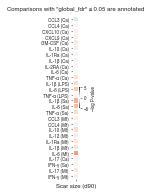

,,Coef,error,p.value,padj,resid.df,sample.size,stat,contrast_fdr,target_fdr,global_fdr
target,contrast,,,,,,,,,,
CYTO:MTB_24h_PBMC_IL.6_good,DONOR_scarSize_v3,0.714579,0.268417,0.008015,0.224429,495.792757,759.0,2.662201,0.008015,0.224429,0.224429
CYTO:S.aureus_24h_PBMC_IL.1b_good,DONOR_scarSize_v3,0.519147,0.215757,0.016455,0.230367,542.135051,833.0,2.406162,0.016455,0.230367,0.230367
CYTO:S.aureus_24h_PBMC_IL.6_good,DONOR_scarSize_v3,0.444702,0.199275,0.026050,0.243130,541.252386,832.0,2.231606,0.026050,0.243130,0.243130
CYTO:LPS.100ng_24h_PBMC_IL.6_good,DONOR_scarSize_v3,0.359928,0.185719,0.053137,0.371960,543.625111,830.0,1.938028,0.053137,0.371960,0.371960
CYTO:S.aureus_24h_PBMC_TNF.a_good,DONOR_scarSize_v3,0.612633,0.397160,0.123518,0.544330,550.538844,831.0,1.542534,0.123518,0.544330,0.544330



----------------------------
I N T E R A C T I O N --- V3
----------------------------
results/LR/PBMC.final.CYTO.BLOOD//LR_results_CYTO.visit_interaction.LMM.remove_evening.csv


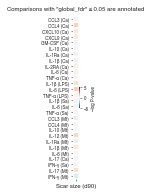

,,Coef,error,p.value,padj,resid.df,sample.size,stat,contrast_fdr,target_fdr,global_fdr
target,contrast,,,,,,,,,,
CYTO:LPS.100ng_24h_PBMC_IL.6_good,DONOR_scarSize_v3,0.351479,0.183966,0.056590,0.820059,540.886055,830.0,1.910560,0.056590,0.820059,0.820059
CYTO:C.albicans.yeast_24h_PBMC_MIP1b_good,DONOR_scarSize_v3,0.280726,0.150157,0.062089,0.820059,539.119038,829.0,1.869546,0.062089,0.820059,0.820059
CYTO:MTB_24h_PBMC_IL.12_good,DONOR_scarSize_v3,0.729287,0.426364,0.087863,0.820059,452.145116,696.0,1.710478,0.087863,0.820059,0.820059
CYTO:MTB_7d_PBMC_IL.17_good,DONOR_scarSize_v3,0.725388,0.497463,0.145390,0.956433,525.559343,804.0,1.458174,0.145390,0.956433,0.956433
CYTO:LPS.100ng_24h_PBMC_IL.1b_good,DONOR_scarSize_v3,0.392196,0.285967,0.170792,0.956433,544.376056,833.0,1.371476,0.170792,0.956433,0.956433


In [4]:
HOST_FACTORS = ['DONOR:IC_TIME_REAL', 'DONOR:AGE', 'DONOR:BMI', 'DONOR:SEX', 'DONOR:oralContraceptivesIncludingMen', 'DONOR:IC_alcoholInLast24h']
FACTORS_ORDER = ['Age', 'Sex', 'BMI', 'Oral contraceptives', 'Alcohol before vaccination', 'Vaccination time']
SCAR_FACTORS = ['DONOR:scarSize_v3']  #  'DONOR:sizeOfVaccinationSpot_v2'
BLOOD_ORDER = ['Monocytes (CD14++CD16{})'.format(utils.MINUS), 'Monocytes (CD14+CD16+)', 'Monocytes (CD14++CD16+)', 'Neutrophils',
               'NK cells (CD3{}CD56+)'.format(utils.MINUS), 'NKT cells (CD3+CD56+)',
               'T cells (CD4+CD25++)', 'T cells (CD4+)', 'T cells (CD8+)', 'B cells (CD19+)']

# corrected for seasonal interaction:
# model_prefix = 'seasonX'

# split analysis (and FDR) by phenotype
# keep_only_adaptive = r'_24h_|aur|bica|actate'
# keep_only_TRIM = r'MTB_|actate'

scar_suppl = {}
for model_prefix, visits, Y_name, blood, factors_kind, subset_factors, subset_targets, exclude_targets, force_order, fig_n in [
    ('final', None, 'CYTO', None, 'include_blood_per_ml', None, None, EXCLUDE, BLOOD_ORDER, '5J'),
    ('final', None, 'CYTO', 'BLOOD', None, HOST_FACTORS, None, EXCLUDE, FACTORS_ORDER, '5K'),
    ('final', None, 'CYTO', 'BLOOD', None, SCAR_FACTORS, None, EXCLUDE, None, None),
]:
    for visit in ['V2', 'V3']:
        ax, res_df, pvals_df, joint_df, de_df = misc.factor_analysis(
            celltype=CELLTYPE, model='{}.{}.{}'.format(model_prefix, Y_name, blood), Y_name=Y_name, factors_kind=factors_kind,
            subset_factors=subset_factors, subset_targets=subset_targets, exclude_targets=exclude_targets, annot_col='global_fdr',
            visits=visits, visit_interaction=visit, fold_changes=None, LMM=True, remove_evening=True,
            factor_volcanos=False, joint_volcano=False, heatmap=True, fdr=FDR,
            age_effect_per_N_years=AGE_EFFECT_PER_N_YEARS,
            scatter_kws=dict(linewidth=CIRCLE_LINE_WIDTH),
            legend_kws=dict(bbox_to_anchor=(2, 1), title='Factor'),
            volcano_kws=dict(size=CIRCLE_SIZE, alpha=ALPHA, figsize=FIG_SIZE, rasterized=False,
                             sharex=False, sharey=False, xlabel='Log2 fold change', fdr_with_hue=True,
                             fdr_pass_color=None, palette=[BLUE, BROWN, CYAN, ORANGE, PINK, GREEN],
                             fdr_fail_color=LIGHT_GRAY, fdr_prefix='FDR '),
            factor_rename_kws=dict(multiline=False, short_rhythm=False, short_contraceptives=False, include_V1_prefix=False),
            force_order=force_order,
            annot_kws={},
            cbar_kws=dict(shrink=0.5),
            heatmap_kws=dict(vmin=LM_VMIN, vmax=LM_VMAX, lw=0.5),
            annot_size=ASTERISK_FONT, max_annot=VOLCANO_MAX_ANNOT,
            cell_width=CELL_SIZE, cell_height=CELL_SIZE, names_without_time=False, names_without_stimulus=False, blank_no_significance=False,
            pval_asterisks=PVAL_ASTERISKS, pval_fmt='.0e',
            cbar_label='{}log P-value'.format(utils.MINUS),
            padj_method='fdr_bh', transpose=True, save_fig=False, show_fig=False, fig_format='svg', dpi=DPI)

        ax.collections[0].colorbar.ax.set_ylabel('{}log P-value'.format(utils.MINUS), fontsize=SMALL_FONT)
        ax.collections[0].colorbar.ax.tick_params(axis='both', which='both', labelsize=SMALL_FONT)
        ax.tick_params(axis='y', which='both', labelsize=SMALL_FONT)
        if SAVE_FIG:
            utils.savefig(os.path.join(fig_dir, 'heatmap.{}{}.{}.svg'.format('_'.join(visits if visits else []), Y_name, factors_kind if factors_kind else '_'.join(subset_factors))))
        plt.show()
        display(res_df.sort_values('p.value').head())

        if SAVE_TABLES:
            suppl_df = misc.suppl_table_immune_LFC_host_factors(res_df, Y_name, visit, factors_kind,
                                                                suppl_tables=None if subset_factors == SCAR_FACTORS else suppl_tables,
                                                                table_name=IMMUNE_ANALYSIS, fig_n=fig_n if visit == 'V3' else None)
            if subset_factors == SCAR_FACTORS:
                scar_suppl[visit] = suppl_df
            else:
                display(suppl_df.head())      

### Baseline cytokines and scar size -- looked at d0 effect in the interaction model (more consistent with Figure 5)

In [13]:
Y_name = 'CYTO'
visit = 'V1'
scar_fn = misc.summary_lr_fn(data='full_results', celltype=CELLTYPE, model='final.{}.BLOOD'.format(Y_name), Y_name=Y_name, visits=None,
                             fold_changes=None, visit_interaction=True, LMM=True, scale=False, remove_evening=True)
scar_df = pd.read_csv(scar_fn, index_col=['target', 'contrast'])
scar_df = scar_df.loc[~scar_df.index.get_level_values('target').str.contains(EXCLUDE)]
scar_df = scar_df.loc[scar_df.index.get_level_values('contrast').isin([scar.replace(':', '_') for scar in SCAR_FACTORS])]
scar_df.loc[:, 'padj'] = misc.adjusted_pvals(scar_df['p.value'], method='fdr_bh')
scar_df = scar_df.sort_values('p.value')

display(scar_df.head())
for i in range(5):
    print(scar_df.index[i], scar_df['padj'].iloc[i])
    
if SAVE_TABLES:
    suppl_df = misc.suppl_table_immune_d0_host_factors(scar_df, Y_name, None, suppl_tables=None)
    scar_suppl[visit] = suppl_df
    
    for visit in scar_suppl:
        scar_suppl[visit]['Data'] = misc.get_day_suffix(visit)
        scar_suppl[visit] = scar_suppl[visit].reset_index().set_index(['Data', LONG_NAMES[Y_name], SCAR_COL])
    suppl_df = pd.concat([scar_suppl[visit] for visit in ['V1', 'V2', 'V3']])
    suppl_df.loc[:, PADJ_COL] = misc.adjusted_pvals(suppl_df.loc[:, PVAL_COL])
    scar_sheet_name = f'{NAMES["CYTO"]}_scarSize'
    suppl_tables[IMMUNE_ANALYSIS]['info'][scar_sheet_name] = f'Association of {HUMAN_NAMES[Y_name]} and and BCG-induced changes in {HUMAN_NAMES[Y_name]} with BCG-induced scar size{misc.related_to_fig_str("5O")}.'
    suppl_tables[IMMUNE_ANALYSIS]['header_rows'][scar_sheet_name] = len(suppl_df.columns.names)
    suppl_tables[IMMUNE_ANALYSIS]['index_cols'][scar_sheet_name] = len(suppl_df.index.names)
    misc.save_excel(suppl_df, suppl_tables[IMMUNE_ANALYSIS]['file'], sheet_name=scar_sheet_name)
    display(suppl_df)

(3668, 7)


,,Coef,error,p.value,padj,resid.df,sample.size,stat
target,contrast,,,,,,,
CYTO:MTB_7d_PBMC_IFNg_good,DONOR_scarSize_v3,2.017943,0.370882,8.335435e-08,0.000002,496.822529,801.0,5.440933
CYTO:MTB_7d_PBMC_IL.17_good,DONOR_scarSize_v3,-2.179970,0.447976,1.471887e-06,0.000021,573.286527,804.0,-4.866267
CYTO:MTB_24h_PBMC_IL.1ra_good,DONOR_scarSize_v3,0.494902,0.290106,8.854065e-02,0.661405,596.343441,760.0,1.705936
CYTO:LPS.100ng_24h_PBMC_IL.6_good,DONOR_scarSize_v3,-0.323551,0.208114,1.207097e-01,0.661405,460.547247,830.0,-1.554678
CYTO:C.albicans.yeast_24h_PBMC_TNF.a_good,DONOR_scarSize_v3,-0.512634,0.341388,1.337480e-01,0.661405,572.784176,770.0,-1.501614


('CYTO:MTB_7d_PBMC_IFNg_good', 'DONOR_scarSize_v3') 2.333921901721098e-06
('CYTO:MTB_7d_PBMC_IL.17_good', 'DONOR_scarSize_v3') 2.060641773807156e-05
('CYTO:MTB_24h_PBMC_IL.1ra_good', 'DONOR_scarSize_v3') 0.6614048007075302
('CYTO:LPS.100ng_24h_PBMC_IL.6_good', 'DONOR_scarSize_v3') 0.6614048007075302
('CYTO:C.albicans.yeast_24h_PBMC_TNF.a_good', 'DONOR_scarSize_v3') 0.6614048007075302


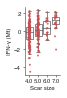

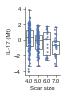

In [6]:
df = misc.get_sample_annot()
df = df.loc[(df['SAMPLE:VISIT'] == 'V1') & (df['SAMPLE:TISSUE'] == 'PBMC') & df['SAMPLE:EXCLUSION'].isnull() & ~df['SAMPLE:VISIT_TIME'].isnull()]
df.loc[df['DONOR:scarSize_v3'] < 0.4, 'DONOR:scarSize_v3'] = 0.4
df.loc[df['DONOR:scarSize_v3'] > 0.7, 'DONOR:scarSize_v3'] = 0.7
df['DONOR:scarSize_v3'] *= 10

for cyto, color in [('V1_CORR_CYTO:MTB_7d_PBMC_IFNg_good', RED), ('V1_CORR_CYTO:MTB_7d_PBMC_IL.17_good', BLUE)]:
    fig, ax = plt.subplots(figsize=(FIG_SIZE[0] * 0.5, FIG_SIZE[1]))
    utils.stripplot(data=df, x='DONOR:scarSize_v3', y=cyto, orient='v', s=2, color=color, alpha=ALPHA, rasterized=RASTER, random_state=misc.RANDOM_STATE)
    sns.boxplot(data=df, x='DONOR:scarSize_v3', y=cyto, orient='v', fliersize=0, color='gray')
    plt.setp(ax.artists, edgecolor='k', facecolor='w', lw=0.5)
    plt.setp(ax.lines, color='k', lw=0.5)
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=35)
    ax.set_xlabel('Scar size')
    ax.set_ylabel(misc.rename_cytokines(cyto.replace('V1_CORR_', '')))
    if SAVE_TABLES:
        # this is only possible if I am keeping all tables from all three visits, then the adjusted p-val is across all thre visists
        ax.set_title(f'p = {suppl_df.loc[("d0", misc.rename_cytokines(cyto.replace("V1_CORR_", ""), with_time=True), "Scar size (d90)"), PADJ_COL]:.1e}')
    sns.despine()
    if SAVE_FIG:
        utils.savefig(os.path.join(fig_dir, 'scars.{}.svg'.format(cyto)), dpi=DPI)
    plt.show()

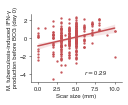

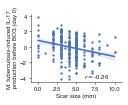

In [39]:
df = misc.get_sample_annot()
df = df.loc[(df['SAMPLE:VISIT'] == 'V1') & (df['SAMPLE:TISSUE'] == 'PBMC') & df['SAMPLE:EXCLUSION'].isnull() & ~df['SAMPLE:VISIT_TIME'].isnull()]
# df.loc[df['DONOR:scarSize_v3'] < 0.4, 'DONOR:scarSize_v3'] = 0.4
# df.loc[df['DONOR:scarSize_v3'] > 0.7, 'DONOR:scarSize_v3'] = 0.7
df['DONOR:scarSize_v3'] *= 10

v1_cols = df.columns.str.contains('^V1_CORR_CYTO:.*_good') & ~df.columns.str.contains('lactate')
v2_cols = df.columns.str.contains('LFC_V2_CYTO:.*_good') & ~df.columns.str.contains('lactate')
v3_cols = df.columns.str.contains('LFC_V3_CYTO:.*_good') & ~df.columns.str.contains('lactate')
assert (v1_cols | v2_cols | v3_cols).sum() == 28 *3

w = 1.3
rs, ps = [], []
cyto_cols = df.columns[v1_cols | v2_cols | v3_cols]
for cyto in cyto_cols:
    if cyto == 'V1_CORR_CYTO:MTB_7d_PBMC_IFNg_good':
        color = RED
    elif cyto == 'V1_CORR_CYTO:MTB_7d_PBMC_IL.17_good':
        color = BLUE
    else:
        color = None
        
    r, p = pearsonr(df.loc[(~df['DONOR:scarSize_v3'].isnull() & ~df[cyto].isnull()), 'DONOR:scarSize_v3'], df.loc[(~df['DONOR:scarSize_v3'].isnull() & ~df[cyto].isnull()), cyto])
    rs.append(r)
    ps.append(p)
    
    if color is not None:
        fig, ax = plt.subplots(figsize=(FIG_SIZE[0] * w, FIG_SIZE[1]))
        sns.regplot(data=df, x='DONOR:scarSize_v3', y=cyto, scatter_kws=dict(s=2, alpha=ALPHA, rasterized=RASTER), color=color)
    #     utils.stripplot(data=df, x='DONOR:scarSize_v3', y=cyto, orient='v', s=2, color=color, alpha=ALPHA, rasterized=RASTER, random_state=misc.RANDOM_STATE)
    #     sns.boxplot(data=df, x='DONOR:scarSize_v3', y=cyto, orient='v', fliersize=0, color='gray')
    #     plt.setp(ax.artists, edgecolor='k', facecolor='w', lw=0.5)
    #     plt.setp(ax.lines, color='k', lw=0.5)
    # #     ax.set_xticklabels(ax.get_xticklabels(), rotation=35)
        ax.set_xlabel('Scar size (mm)')
        ax.set_ylabel(f"M. tuberculosis-induced {misc.rename_cytokines(cyto.replace('V1_CORR_', '')).replace('(Mt)', '')}\n production before BCG (day 0)")
        ax.set_xlim([ax.get_xlim()[0] - 0.9, ax.get_xlim()[1] + 0.9])
        ax.text(6, -4, f'$r=${r:.2f}')
        ax.set_xticks([0, 2.5, 5, 7.5, 10])
    #     if SAVE_TABLES:
    #         # this is only possible if I am keeping all tables from all three visits, then the adjusted p-val is across all thre visists
            # ax.set_title(f'p = {suppl_df.loc[("d0", misc.rename_cytokines(cyto.replace("V1_CORR_", ""), with_time=True), "Scar size (d90)"), PADJ_COL]:.1e}')
        sns.despine()
        
        if SAVE_FIG:
            utils.savefig(os.path.join(fig_dir, f'scars.{cyto}.w{w}.svg'), dpi=DPI)
        plt.show()
assert len(rs) == len(ps) and len(rs) == 28 * 3
rs = pd.Series(rs, index=cyto_cols, name='r')
ps = pd.Series(ps, index=cyto_cols, name='p')
p_adj = misc.adjusted_pvals(ps)

In [45]:
scar_corr_df = pd.concat([rs, ps, p_adj], axis=1).sort_values('p')
scar_corr_df.head(10)
for i in range(2):
    display(scar_corr_df.iloc[i])

r       2.947449e-01
p       2.297458e-07
padj    1.929864e-05
Name: V1_CORR_CYTO:MTB_7d_PBMC_IFNg_good, dtype: float64

r      -0.256919
p       0.000007
padj    0.000296
Name: V1_CORR_CYTO:MTB_7d_PBMC_IL.17_good, dtype: float64

### Seasonal analysis

In [10]:
df = misc.get_sample_annot()
days_in_a_year = df['SAMPLE:VISIT_DAYS_FROM_20170101'] / df['SAMPLE:VISIT_DATE_REAL']
np.unique(days_in_a_year.loc[~days_in_a_year.isnull()]).tolist()

[365.2424999999999,
 365.24249999999995,
 365.2425,
 365.24250000000006,
 365.2425000000001]


----------------------------
I N T E R A C T I O N --- V2
----------------------------
results/LR/PBMC.final.simple_season_with_LMM_covar.CYTO.BLOOD//LR_results_CYTO.visit_interaction.LMM.remove_evening.DONOR:IC_DATE_2PI_SIN__DONOR:IC_DATE_2PI_COS.csv


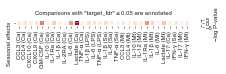

Lactate (Ca)    0.001469
GM-CSF (Ca)     0.036341
Name: padj, dtype: float64
The precise xticks are: ['2017-01-01', '2017-07-02', '2018-01-01', '2018-07-02', '2019-01-01']
peak date for Lactate (Ca) 2017-05-07
peak date for GM-CSF (Ca) 2017-11-26


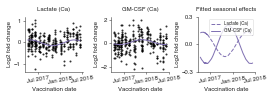

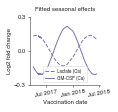


----------------------------
I N T E R A C T I O N --- V3
----------------------------
results/LR/PBMC.final.simple_season_with_LMM_covar.CYTO.BLOOD//LR_results_CYTO.visit_interaction.LMM.remove_evening.DONOR:IC_DATE_2PI_SIN__DONOR:IC_DATE_2PI_COS.csv


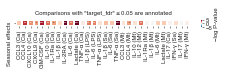

Lactate (Ca)    4.321385e-10
TNF-α (Sa)      1.123953e-06
IL-2RA (Ca)     3.107693e-05
GM-CSF (Ca)     5.109382e-04
CCL4 (Ca)       1.350887e-03
IL-10 (Ca)      6.906693e-03
IL-6 (Ca)       6.906693e-03
IL-12 (Mt)      7.584663e-03
IL-1β (LPS)     8.412114e-03
IL-6 (LPS)      8.412114e-03
CXCL10 (Ca)     1.401376e-02
CXCL9 (Ca)      1.932247e-02
IL-1Ra (Ca)     1.932247e-02
CCL4 (Mt)       1.932247e-02
Name: padj, dtype: float64
The precise xticks are: ['2017-01-01', '2017-07-02', '2018-01-01', '2018-07-02', '2019-01-01']
peak date for Lactate (Ca) 2017-04-09
peak date for TNF-α (Sa) 2017-11-19
peak date for IL-2RA (Ca) 2018-01-31
peak date for GM-CSF (Ca) 2017-11-19
peak date for CCL4 (Ca) 2018-01-10
peak date for IL-10 (Ca) 2018-02-25
peak date for IL-6 (Ca) 2018-01-10
peak date for IL-12 (Mt) 2018-01-02
peak date for IL-1β (LPS) 2017-11-26
peak date for IL-6 (LPS) 2018-01-02
peak date for CXCL10 (Ca) 2018-01-10
peak date for CXCL9 (Ca) 2018-01-02
peak date for IL-1Ra (Ca) 2018-03-07

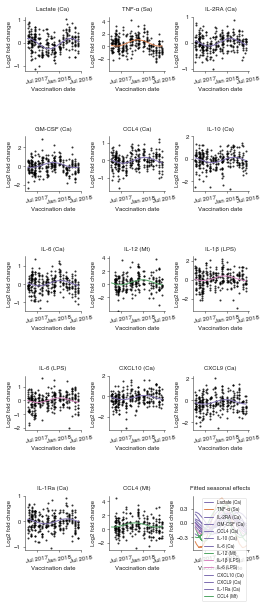

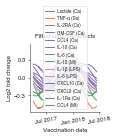


----------------------------
I N T E R A C T I O N --- V2
----------------------------
results/LR/PBMC.final.CYTO.BLOOD//LR_results_CYTO.visit_interaction.LMM.remove_evening.DONOR:IC_DATE_2PI_SIN__DONOR:IC_DATE_2PI_COS.csv


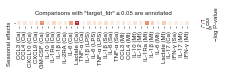

,Coefficient (cosine),Coefficient (sine),F-value,P-value,Adjusted P-value
Cytokine,,,,,
"CCL3 (Ca, 24h)",0.043041,-0.040277,0.916097,0.400641,0.651203
"CCL3 (Mt, 24h)",-0.302177,-0.000899,1.366770,0.255985,0.524408
"CCL4 (Ca, 24h)",0.059130,0.041795,1.499422,0.224045,0.522011
"CCL4 (Mt, 24h)",-0.071648,0.057216,0.449487,0.638199,0.736253
"CXCL10 (Ca, 24h)",0.055278,0.041658,0.565865,0.568173,0.721658


Lactate (Ca)    0.005747
IL-1Ra (Mt)     0.048406
GM-CSF (Ca)     0.048406
Name: padj, dtype: float64
The precise xticks are: ['2017-01-01', '2017-07-02', '2018-01-01', '2018-07-02', '2019-01-01']
peak date for Lactate (Ca) 2018-04-18
peak date for IL-1Ra (Mt) 2018-06-06
peak date for GM-CSF (Ca) 2017-11-19


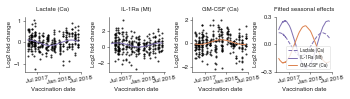

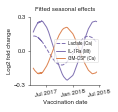


----------------------------
I N T E R A C T I O N --- V3
----------------------------
results/LR/PBMC.final.CYTO.BLOOD//LR_results_CYTO.visit_interaction.LMM.remove_evening.DONOR:IC_DATE_2PI_SIN__DONOR:IC_DATE_2PI_COS.csv


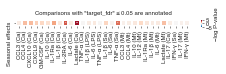

,Coefficient (cosine),Coefficient (sine),F-value,P-value,Adjusted P-value
Cytokine,,,,,
"CCL3 (Ca, 24h)",0.056548,-0.076069,0.929114,0.395551,0.547380
"CCL3 (Mt, 24h)",0.237824,-0.046230,0.566504,0.567829,0.655188
"CCL4 (Ca, 24h)",0.165951,-0.013197,3.560641,0.029170,0.138097
"CCL4 (Mt, 24h)",0.123022,-0.130196,0.869575,0.419658,0.547380
"CXCL10 (Ca, 24h)",0.205042,-0.048661,3.647281,0.026613,0.138097


Lactate (Ca)    0.001600
IL-2RA (Ca)     0.011369
TNF-α (Sa)      0.017602
Name: padj, dtype: float64
The precise xticks are: ['2017-01-01', '2017-07-02', '2018-01-01', '2018-07-02', '2019-01-01']
peak date for Lactate (Ca) 2018-02-25
peak date for IL-2RA (Ca) 2018-01-07
peak date for TNF-α (Sa) 2017-11-01


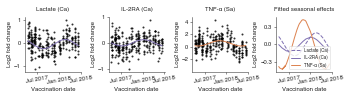

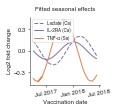

In [11]:
Y_name = 'CYTO'
coefs_suffix = 'DONOR:IC_DATE_2PI_SIN__DONOR:IC_DATE_2PI_COS'
fn_suffix = fn_suffix = misc.lr_fn_suffix(visit_interaction=True, LMM=True, remove_evening=True)
for model, lfc_coef, make_suppl_table, fig_n in [
    ('final.simple_season_with_LMM_covar.{}.BLOOD'.format(Y_name), 'SAMPLE_VISIT[T.{}]', False, 'S4D'),
    ('final.{}.BLOOD'.format(Y_name), 'SAMPLE_VISIT_{}', True, '5L')
]:
    for visit in ['V2', 'V3']:
        res_df, _, _, _ = misc.factor_analysis(
            CELLTYPE, model, Y_name, factors_kind='include_season', annot_col='target_fdr',
            visits=False, visit_interaction=visit, fold_changes=False, LMM=True, remove_evening=True,
            subset_factors=None, subset_targets=False, exclude_targets=r'C\.albicans\.yeast_24h_PBMC_IFNg',
            factor_volcanos=False, joint_volcano=False, heatmap=True, fdr=FDR,
            annot_kws={}, cbar_kws={}, heatmap_kws=dict(vmin=LM_VMIN, vmax=LM_VMAX),
            annot_size=ASTERISK_FONT, max_annot=VOLCANO_MAX_ANNOT,
            cell_width=CELL_SIZE, cell_height=CELL_SIZE, names_without_time=False,
            names_without_stimulus=False, blank_no_significance=False,
            pval_asterisks=PVAL_ASTERISKS, pval_fmt='.0e',
            cbar_label='{}log P-value'.format(utils.MINUS),
            padj_method='fdr_bh', save_fig=SAVE_FIG, show_fig=True, fig_format='pdf')

        res_df = res_df.loc[res_df.index.get_level_values('contrast') == 'SEASON'].droplevel('contrast')    
        coefs_df = pd.read_csv(
            misc.lr_fn(CELLTYPE, model, Y_name, data='coefs', extras='{}.{}'.format(coefs_suffix, fn_suffix), ext='csv'),
            index_col=['target', 'contrast']
        )
        cos_coefs_df = coefs_df.loc[coefs_df.index.get_level_values('contrast') == 'SAMPLE_VISIT[T.{}]:DONOR_IC_DATE_2PI_COS'.format(visit)]
        sin_coefs_df = coefs_df.loc[coefs_df.index.get_level_values('contrast') == 'SAMPLE_VISIT[T.{}]:DONOR_IC_DATE_2PI_SIN'.format(visit)]
        
        if make_suppl_table and SAVE_TABLES:
            suppl_df = misc.suppl_table_immune_LFC_season(res_df, cos_coefs_df, sin_coefs_df, Y_name, visit, suppl_tables=suppl_tables, table_name=IMMUNE_ANALYSIS, fig_n=fig_n if visit == 'V3' else None)
            display(suppl_df.head())

        res_df.index = misc.rename_cytokines(res_df.index.get_level_values('target'))
        print(res_df.loc[res_df['padj'] < np.min(FDR)].sort_values('p.value')['padj'])

        df = misc.get_sample_annot()
        cyto_df = df.loc[(df['SAMPLE:VISIT'] == visit) & (df['SAMPLE:TISSUE'] == 'PBMC') & ~df['DONOR:IC_EVENING'] & ~df['DONOR:IC_DATE_REAL'].isnull(),
                         df.columns.str.contains('^LFC_CORR_CYTO:.*_good$')]
        cyto_df.columns = cyto_df.columns.str.replace('^LFC_', '').str.replace('^CORR_', '')
        cyto_df.columns = misc.rename_cytokines(cyto_df.columns)

        hits = res_df.sort_values('p.value').loc[res_df['target_fdr'] < np.min(FDR)].index.values
        ncols = 3 if len(hits) + 1 > 5 else len(hits) + 1
        nrows = int(np.ceil((len(hits) + 1) / ncols))
        assert nrows * ncols >= len(hits) + 1, (nrows * ncols, len(hits) + 1)
        colors = [PURPLE, PURPLE, ORANGE] if len(hits) < 4 else [PURPLE if c.endswith('(Ca)') else PINK if c.endswith('(LPS)') else ORANGE if c.endswith('(Sa)') else GREEN if c.endswith('(Mt)') else '???' for c in hits]
        linestyles = ['--', '-', '-'] if len(hits) < 4 else (['-'] * len(hits))
        
        fig, axs = plt.subplots(nrows, ncols, figsize=(FIG_SIZE[0] * ncols * (1.1 if nrows == 1 else 1.068), FIG_SIZE[1] * nrows * (0.80 if nrows == 1 else 1.57)), squeeze=False)
        plt.subplots_adjust(wspace=0.5, hspace=1.2 if nrows > 1 else 0)
        previous_xtick_dates = None
        fig2, ax2 = plt.subplots(1, 1, figsize=FIG_SIZE)
        for ax, cyto, color, ls in zip(axs.flatten(), hits, colors, linestyles):
            ax = sns.scatterplot(x=df.loc[cyto_df.index, 'DONOR:IC_DATE_REAL'], y=cyto_df[cyto], ax=ax,
                                 color='black', alpha=ALPHA, linewidth=0, s=CIRCLE_SIZE * 0.2, edgecolor='red', rasterized=RASTER)
            if cyto in ['IL-2RA (Ca)', 'IL-1Ra (Ca)']:
                ax.set_ylim(ax.get_ylim()[0], max(1, ax.get_ylim()[1]))
            elif cyto in ['IL-10 (Ca)', 'CXCL10 (Ca)']:
                ax.set_ylim(ax.get_ylim()[0], max(2, ax.get_ylim()[1]))
            ax.set_title(cyto)
            ax.set_ylabel('Log2 fold change')
            ax.set_xlabel('Vaccination date')
            ax.set_xticklabels([misc.convert_partial_year(xtick).date().strftime("%b %Y") for xtick in ax.get_xticks()], rotation=10)

            fitted = 0
            for single_coefs_df, X_col in [(cos_coefs_df, 'DONOR:IC_DATE_2PI_COS'), (sin_coefs_df, 'DONOR:IC_DATE_2PI_SIN')]:
                coef = single_coefs_df.loc[misc.rename_cytokines(single_coefs_df.index.get_level_values('target')) == cyto]
                assert len(coef) == 1
                fitted += coef['Coef'].iloc[0] * df.loc[cyto_df.index, X_col]
            lfc = coefs_df.loc[(misc.rename_cytokines(coefs_df.index.get_level_values('target')) == cyto) &
                                (coefs_df.index.get_level_values('contrast') == lfc_coef.format(visit))]
            assert len(lfc) == 1
            lfc = lfc['Coef'].iloc[0]

            fitted_lines = {'x': df.loc[cyto_df.index, 'DONOR:IC_DATE_REAL'], 'y': fitted, 'lfc': lfc}
            ax.plot(fitted_lines['x'], fitted_lines['y'] + fitted_lines['lfc'], ls='-', c=color)
            if ax.get_ylim()[0] < -4:
                ax.set_ylim((-4, ax.get_ylim()[1]))
                ax.set_yticks([-2, 0, 2, 4])

            for comp_ax in [axs[-1, -1], ax2]:
                comp_ax.plot(fitted_lines['x'], fitted_lines['y'], label=cyto, ls=ls, c=color)
                comp_ax.legend(fontsize=SMALL_FONT)
                comp_ax.set_ylabel('Log2 fold change')
                comp_ax.set_title('Fitted seasonal effects')
                xtick_dates = [misc.convert_partial_year(xtick).date() for xtick in comp_ax.get_xticks()]
                if previous_xtick_dates is None:
                    print('The precise xticks are:', [str(d) for d in xtick_dates])
                    previous_xtick_dates = xtick_dates
                else:
                    assert [str(d) for d in xtick_dates] == [str(d) for d in previous_xtick_dates] 

                comp_ax.set_xticklabels([d.strftime("%b %Y") for d in xtick_dates], rotation=10)
                comp_ax.set_xlabel('Vaccination date')
                comp_ax.set_yticks([-0.3, 0, 0.3])

            _sort = np.argsort(fitted_lines['y'])[::-1]
            print('peak date for', cyto, np.asarray([misc.convert_partial_year(date_real).date() for date_real in fitted_lines['x'].iloc[_sort]])[0])

        sns.despine(fig)
        sns.despine(fig2)
        if SAVE_FIG:
            utils.savefig(os.path.join(fig_dir, 'seasonality.{}.{}.svg'.format(model, visit)), fig=fig, dpi=DPI)
            utils.savefig(os.path.join(fig_dir, 'seasonality.{}.{}.combined_only.svg'.format(model, visit)), fig=fig2, dpi=DPI)
        plt.show()

In [12]:
if SAVE_TABLES:
    infos, tables = misc.close_tables_and_save(suppl_tables)
    for table, df in zip(tables, infos):
        print(table)
        display(df)

S02_immune_functions


,Contents
Sheet name,
cellFreq_corr,Pairwise Spearman correlations of frequencies ...
inflaMark_corr,Pairwise Spearman correlations of 73 circulati...
cytokine_corr,Pairwise Spearman correlations of 28 ex vivo c...
cellFreq_donorVar,Fraction of variance explained (FVE) by donor ...
inflaMark_donorVar,Fraction of variance explained (FVE) by donor ...
cytokine_donorVar,Fraction of variance explained (FVE) by donor ...
cytokine_d0_cellFreq,Association of cytokine production capacity wi...
cellFreq_d0_hostFactors,Association of immune cell frequencies with ho...
inflaMark_d0_hostFactors,Association of inflammatory marker concentrati...


In [13]:
misc.fix_font_for_suppl_tables(suppl_tables)